Dataset citation: Kermany, Daniel; Zhang, Kang; Goldbaum, Michael (2018), “Labeled Optical Coherence Tomography (OCT) and Chest X-Ray Images for Classification”, Mendeley Data, V2, doi: 10.17632/rscbjbr9sj.2

http://www.cell.com/cell/fulltext/S0092-8674(18)30154-5

### [Package load]

In [31]:
import torch
print('pytorch version: {}'.format(torch.__version__))

pytorch version: 2.2.2


In [32]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
%matplotlib inline

print('pytorch version: {}'.format(torch.__version__))
print('GPU 사용 가능 여부: {}'.format(torch.cuda.is_available()))
device = "cuda" if torch.cuda.is_available() else "cpu"   # GPU 사용 가능 여부에 따라 device 정보 저장

pytorch version: 2.2.2
GPU 사용 가능 여부: False


In [33]:
# 이걸 해줘야 matplotlib 시행 시 에러가 안 남
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

### [For Colab]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

from pathlib import Path

folder = "인공지능 공부" # 상위 directory
project_dir = "[Kaggle] Retinal OCT Images (optical coherence tomography)제목없는 폴더" # 폴더 이름
base_path = Path("/content/drive/MyDrive/")
project_path = base_path / folder / project_dir

os.chdir(project_path)
for x in list(project_path.glob("*")):
    if x.is_dir():
        dir_name = str(x.relative_to(project_path))
        os.rename(dir_name, dir_name.split(" ", 1)[0])
print(f"현재 디렉토리 위치: {os.getcwd()}")

### [Setting Hyperparameters]

In [34]:
batch_size = 64
num_epochs = 30
learning_rate = 0.001

### [Dataset & DataLoader]

- ##### 3 channel: Input을 3번 concat -> (3,224,224)

In [5]:
data_dir = '../data/OCT'  # 압축 해제된 데이터셋의 디렉토리 경로

# For Kaggle notebook
#data_dir = '/kaggle/input/kermany2018/OCT2017 /'

In [6]:
class OCTDataset(Dataset):
    def __init__(self, data_dir, mode, transform=None):
        self.all_data = sorted(glob.glob(os.path.join(data_dir, mode,'*', '*')))
        self.transform = transform
    
    def __getitem__(self, index):
        data_path = self.all_data[index]
        img = Image.open(data_path)
        if self.transform is not None:
            img = self.transform(img)
        img = img.squeeze()
        img = torch.stack((img, img, img,), dim=0)  # VGG16이 3 channel이라 concat시키기
        name = os.path.basename(data_path)
        if name.startswith('NORMAL'):
            label = 0
        elif name.startswith('CNV'):
            label = 1
        elif name.startswith('DME'):
            label = 2
        elif name.startswith('DRUSEN'):
            label = 3
        return img, label
    
    def __len__(self):
        length = len(self.all_data)
        return length

In [7]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(5),
        transforms.RandomResizedCrop(224, scale=(0.96, 1.0), ratio=(0.95, 1.05)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(0.1881,0.1850)
    ]),
    'val': transforms.Compose([
        transforms.Resize([256]),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(0.1881,0.1850)
    ])
}

In [8]:
train_data = OCTDataset(data_dir=data_dir, mode='train', transform=data_transforms['train'])
val_data = OCTDataset(data_dir=data_dir, mode='val', transform=data_transforms['val'])
test_data = OCTDataset(data_dir=data_dir, mode='test', transform=data_transforms['val'])

In [9]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=False)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, drop_last=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, drop_last=False)

In [10]:
train_mean = 0.1881
train_std = 0.1850

### [Model: MobileNet]

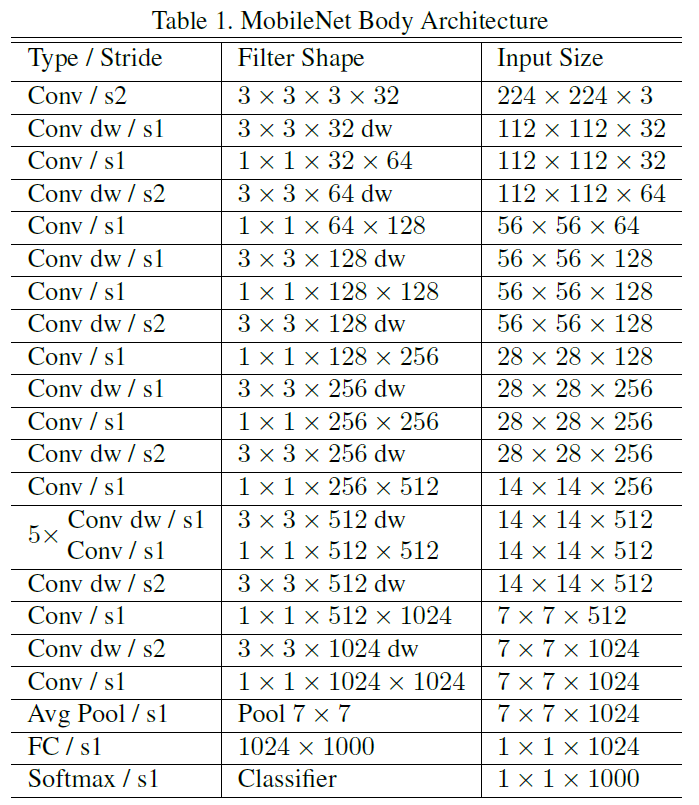

In [35]:
class DepthPointConv(nn.Module):
    def __init__(self, in_channel, out_channel, depth_stride, point_stride):
        super().__init__()
        self.depthwise = nn.Sequential(
            nn.Conv2d(in_channel, in_channel, 3, stride = depth_stride, groups=in_channel, padding=1, bias=False),  #groups에 in channel을 하면 각각의 input channel이 각각의 output channel에 대응되어 convolution 연산
            nn.BatchNorm2d(in_channel),
            nn.ReLU(inplace = True)
        )
        self.pointwise = nn.Sequential(
            nn.Conv2d(in_channel, out_channel, 3, stride = point_stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channel),
            nn.ReLU(inplace = True)
        )

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x


class MobileNet(nn.Module):
    def __init__(self, num_classes, alpha=1.0):    # alpha = width multiplier (0, 1] -> Width를 줄여주는 효과 = model을 더 축소시키는 효과
        super().__init__()
        self.stem_conv = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride = 2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace = True)
        )
        self.convblock1 = nn.Sequential(
            DepthPointConv(in_channel=int(32*alpha), out_channel=int(64*alpha), depth_stride=1, point_stride=1),
            DepthPointConv(in_channel=int(64*alpha), out_channel=int(128*alpha), depth_stride=2, point_stride=1),
            DepthPointConv(in_channel=int(128*alpha), out_channel=int(128*alpha), depth_stride=1, point_stride=1),
            DepthPointConv(in_channel=int(128*alpha), out_channel=int(256*alpha), depth_stride=2, point_stride=1),
            DepthPointConv(in_channel=int(256*alpha), out_channel=int(256*alpha), depth_stride=1, point_stride=1),
            DepthPointConv(in_channel=int(256*alpha), out_channel=int(512*alpha), depth_stride=2, point_stride=1)
        )
        self.convblock2 = nn.Sequential(
            DepthPointConv(in_channel=int(512*alpha), out_channel=int(512*alpha), depth_stride=1, point_stride=1),
            DepthPointConv(in_channel=int(512*alpha), out_channel=int(512*alpha), depth_stride=1, point_stride=1),
            DepthPointConv(in_channel=int(512*alpha), out_channel=int(512*alpha), depth_stride=1, point_stride=1),
            DepthPointConv(in_channel=int(512*alpha), out_channel=int(512*alpha), depth_stride=1, point_stride=1),
            DepthPointConv(in_channel=int(512*alpha), out_channel=int(512*alpha), depth_stride=1, point_stride=1)
        )
        self.convblock3 = nn.Sequential(
            DepthPointConv(in_channel=int(512*alpha), out_channel=int(1024*alpha), depth_stride=2, point_stride=1),
            DepthPointConv(in_channel=int(1024*alpha), out_channel=int(1024*alpha), depth_stride=2, point_stride=1),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(in_features=1024, out_features=num_classes, bias=True)
    
    def forward(self, x):
        x = self.stem_conv(x)
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)       # x.size(0) = batch size
        x = self.fc(x)
        return x

In [36]:
mobilenet_v1 = MobileNet(num_classes=4).to(device)

In [37]:
mobilenet_v1

MobileNet(
  (stem_conv): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (convblock1): Sequential(
    (0): DepthPointConv(
      (depthwise): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (pointwise): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (1): DepthPointConv(
      (depthwise): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=64, bias=False)
        (1): BatchNorm2d(64, 

In [38]:
temp = torch.Tensor(np.random.randint(1, 255, size=(1, 3, 224, 224)))
mobilenet_v1(temp)

tensor([[-0.0238, -0.0413,  0.2786, -0.1109]], grad_fn=<AddmmBackward0>)

In [39]:
from torchsummary import summary
summary(mobilenet_v1, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             896
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              ReLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
              ReLU-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 64, 112, 112]          18,432
       BatchNorm2d-8         [-1, 64, 112, 112]             128
              ReLU-9         [-1, 64, 112, 112]               0
   DepthPointConv-10         [-1, 64, 112, 112]               0
           Conv2d-11           [-1, 64, 56, 56]             576
      BatchNorm2d-12           [-1, 64, 56, 56]             128
             ReLU-13           [-1, 64, 56, 56]               0
           Conv2d-14          [-1, 128,

In [40]:
from torchinfo import summary
summary(mobilenet_v1, input_size=(1, 3, 224, 224), col_width=20, depth=100, row_settings=["depth", "var_names"], col_names=["input_size", "kernel_size", "output_size", "params_percent"])

Layer (type (var_name):depth-idx)             Input Shape          Kernel Shape         Output Shape         Param %
MobileNet (MobileNet)                         [1, 3, 224, 224]     --                   [1, 4]                    --
├─Sequential (stem_conv): 1-1                 [1, 3, 224, 224]     --                   [1, 32, 112, 112]         --
│    └─Conv2d (0): 2-1                        [1, 3, 224, 224]     [3, 3]               [1, 32, 112, 112]      0.00%
│    └─BatchNorm2d (1): 2-2                   [1, 32, 112, 112]    --                   [1, 32, 112, 112]      0.00%
│    └─ReLU (2): 2-3                          [1, 32, 112, 112]    --                   [1, 32, 112, 112]         --
├─Sequential (convblock1): 1-2                [1, 32, 112, 112]    --                   [1, 512, 14, 14]          --
│    └─DepthPointConv (0): 2-4                [1, 32, 112, 112]    --                   [1, 64, 112, 112]         --
│    │    └─Sequential (depthwise): 3-1       [1, 32, 112, 112] 

### [Saving checkpoints]

In [24]:
def save_model(model, epoch, optimizer, epoch_loss, val_accuracy, saved_dir):
    os.makedirs(saved_dir, exist_ok=True)
    check_point = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': epoch_loss
    }
    val_accuracy = round(val_accuracy,1)
    file_name = str(f"ckpoint_{epoch+1}_{val_accuracy}%.pt")
    output_path = os.path.join(saved_dir, file_name)
    torch.save(check_point,output_path)

### [Loss tracker]

##### Visdom for local setting

In [ ]:
import visdom

vis = visdom.Visdom()
vis.close(env="main")

In [ ]:
def loss_tracker(loss_plot, loss_value, num):
    '''num, loss_value, are Tensor'''
    vis.line(X=num,
             Y=loss_value,
             win = loss_plot,
             update='append'
             )

In [ ]:
loss_plt = vis.line(Y=torch.Tensor(1).zero_(),opts=dict(title='loss_tracker', legend=['loss'], showlegend=True))

##### Tensorboard

In [25]:
logs_base_dir = "./logs/logs_simple"
os.makedirs(logs_base_dir, exist_ok=True)

from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter(logs_base_dir)

### [Defining Train, Val, Test Function]

In [26]:
def train(num_epochs, model, data_loader, criterion, optimizer, scheduler, val_every, device, saved_dir, writer):
    print('Start training..')
    torch.cuda.empty_cache()
    best_loss = 9999999
    train_loss_list = []
    val_loss_list = []
    train_accuracy_list = []
    val_accuracy_list = []
    best_epoch = 0
    count = 0
    for epoch in tqdm(range(num_epochs), desc='epoch'):
        # running_loss = 0.0
        for i, (imgs, labels) in tqdm(enumerate(data_loader), desc="in epoch"):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Saving train loss
            train_loss_list.append(loss.item())

            _, argmax = torch.max(outputs, 1)
            accuracy = (labels == argmax).float().mean()
            # Saving train accuracy
            train_accuracy_list.append(accuracy)

            if (i+1) % 30 == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'.format(
                    epoch+1, num_epochs, i+1, len(data_loader), loss.item(), accuracy.item() * 100))
            if (i+1) % 50 == 0:
                writer.add_scalar('Loss/Train', loss, i)
                writer.add_scalar('Accuracy/Train', accuracy, i)
            #if i % 30 == 29:
                #loss_tracker(loss_plt, torch.Tensor([running_loss/30]), torch.Tensor([i + epoch*len(trainloader) ]))
                #running_loss = 0.0
        if (epoch + 1) % val_every == 0:
            avrg_loss, val_accuracy = validation(epoch + 1, model, val_loader, criterion, device)
            # Saving validation loss and accuracy
            val_loss_list.append(avrg_loss)
            writer.add_scalar('Loss/Validation', avrg_loss, epoch+1)
            val_accuracy_list.append(val_accuracy)
            writer.add_scalar('Accuracy/Validation', val_accuracy, epoch+1)
            if avrg_loss < best_loss:
                print('Best performance at epoch: {}'.format(epoch + 1))
                print('Save model in', saved_dir)
                best_loss = avrg_loss
                save_model(model, epoch, optimizer, avrg_loss, val_accuracy, saved_dir)
                count = 0
                best_epoch = epoch + 1
            else:
                count += 1
                print(f'Best epoch does not appear / Previous best epoch:{best_epoch}')
                print(f'A number of epochs remain until early stop: {10-count}')
                if count >= 10:
                    print('Best performance does not occur within 10 epochs. Early stopping!!')
                    scheduler.step()
                    writer.flush()
                    return train_loss_list, val_loss_list, train_accuracy_list, val_accuracy_list
            ''' Only for local setting
            loss_tracker(loss_plt, torch.Tensor([avrg_loss]), torch.Tensor([epoch]))'''
    scheduler.step()
    writer.flush()
    return train_loss_list, val_loss_list, train_accuracy_list, val_accuracy_list

In [27]:
def validation(epoch, model, data_loader, criterion, device):
    print('Start validation #{}'.format(epoch) )
    model.eval()
    with torch.no_grad():
        total = 0
        correct = 0
        total_loss = 0
        cnt = 0
        for i, (imgs, labels) in enumerate(data_loader):
            imgs, labels = imgs.to(device), labels.to(device)

            outputs = model(imgs)
            loss = criterion(outputs,labels)
            
            total += imgs.size(0)
            _, argmax = torch.max(outputs, 1)
            correct += (labels == argmax).sum().item()
            total_loss += loss
            cnt += 1
        avrg_loss = total_loss / cnt
        val_accuracy = correct / total * 100
        print('Validation #{}  Accuracy: {:.2f}%  Average Loss: {:.4f}'.format(epoch, val_accuracy, avrg_loss))
    model.train()
    return avrg_loss, val_accuracy

In [28]:
def test(model, data_loader, device):
    print('Start test..')
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        answer_list = []
        pred_list = []
        pred_proba_list = []
        
        for i, (imgs, labels) in tqdm(enumerate(data_loader)):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)

            pred_probability = F.softmax(outputs, dim=1)
            pred_proba_list.append(pred_probability.tolist())
            
            _, argmax = torch.max(outputs, 1)
            pred_list.append(argmax.tolist())

            total += imgs.size(0)
            correct += (labels == argmax).sum().item()
            
            answer_list.append(labels.tolist())
        
        print('Test accuracy for {} images: {:.2f}%'.format(total, correct / total * 100))
    model.train()        
    return pred_list, answer_list, pred_proba_list

### [Loss function, Optimizer, Directory for saving]

In [29]:
torch.manual_seed(7777)

criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(mobilenet_v1.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0.00001)

val_every = 1
saved_dir = './saved'

### [Train]

In [ ]:
train_loss_list, val_loss_list, train_accuracy_list, val_accuracy_list = train(num_epochs, mobilenet_v1, train_loader, criterion, optimizer, scheduler, val_every, device, saved_dir, writer)

##### Visualizing train loss and accuracy

- With matplotlib in colab setting

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.ylabel('Loss')
plt.plot(train_loss_list, label = 'Train')
plt.plot(val_loss_list, label = 'Validation')
plt.subplot(1,2,2)
plt.ylabel('Accuracy')
plt.plot(train_accuracy_list, label = 'Train')
plt.plot(val_accuracy_list, label = 'Validation')
# plt.savefig('graph.png',facecolor = 'w')
plt.show()

- With Tensorboard

In [ ]:
%load_ext tensorboard
%tensorboard --logdir='./logs/logs_simple'

### [Test]

##### Loading best model

In [ ]:
mobilenet_test = MobileNet(num_classes=4).to(device) 
model_path = './saved/.pt'    # .pt 앞에 파일 이름 붙이기
checkpoint = torch.load(model_path, map_location=device)
state_dict = checkpoint['model_state_dict']
mobilenet_test.load_state_dict(state_dict)
mobilenet_test.eval()

##### Actual test

In [ ]:
with torch.no_grad():
    pred_list, answer_list, pred_proba_list = test(mobilenet_test, test_loader, device)